<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Serum-neutralization-and-binding-to-wildtype-HA" data-toc-modified-id="Serum-neutralization-and-binding-to-wildtype-HA-1">Serum neutralization and binding to wildtype HA</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1.1">Overview</a></span></li><li><span><a href="#Import-Python-packages" data-toc-modified-id="Import-Python-packages-1.2">Import Python packages</a></span></li><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1.3">Configuration and setup</a></span></li><li><span><a href="#Read-neutralization-data" data-toc-modified-id="Read-neutralization-data-1.4">Read neutralization data</a></span></li><li><span><a href="#Fit-and-plot-neutralization-curves" data-toc-modified-id="Fit-and-plot-neutralization-curves-1.5">Fit and plot neutralization curves</a></span></li><li><span><a href="#Compare-neutralization-to-binding-data" data-toc-modified-id="Compare-neutralization-to-binding-data-1.6">Compare neutralization to binding data</a></span></li><li><span><a href="#Examine-concentrations-for-mutational-antigenic-profiling" data-toc-modified-id="Examine-concentrations-for-mutational-antigenic-profiling-1.7">Examine concentrations for mutational antigenic profiling</a></span></li></ul></li></ul></div>

# Serum neutralization and binding to wildtype HA

## Overview
Here we analyze neutralization assays of the serum against virus with the wildtype Perth/2009 HA.
We then compare the IC50s to the binding titers measured as part of the [Nhat et al (2017)](https://www.nature.com/articles/s41598-017-06177-0) study that characterized these IC50s.

The neutralization assays where set up using the "Rachel-style 2019" format on the Bloom lab plate reader as [described here](https://jbloomlab.github.io/neutcurve/rachelstyle2019_example.html), so we can analyze the raw Excel data off the plate reader.

## Import Python packages
We use the Bloom lab [neutcurve](https://jbloomlab.github.io/neutcurve) package for fitting neutralization curves, and [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting:

In [1]:
import os
import warnings

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

import neutcurve
from neutcurve.colorschemes import CBPALETTE
import neutcurve.parse_excel

print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.3.0


Set output format of pandas Data Frames:

In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

Hide warnings that can clutter output:

In [3]:
warnings.simplefilter('ignore')

## Configuration and setup
Read general configuration from [config.yaml](config.yaml):

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the neutralization assay configuration from the specified file:

In [5]:
print(f"Reading neutralization assay setup from {config['wt_neut_config']}")

with open(config['wt_neut_config']) as f:
    neut_config = yaml.safe_load(f)

Reading neutralization assay setup from data/wt_neut_config.yaml


Get the output directory:

In [6]:
outdir = config['wt_neut_and_bind_outdir']
os.makedirs(outdir, exist_ok=True)
print(f"Output will be written to {outdir}")

Output will be written to results/wt_neut_and_bind


## Read neutralization data
Next, for each dict in *neut_config*, we use
[neutcurve.parse_excel.parseRachelStyle2019](https://jbloomlab.github.io/neutcurve/neutcurve.parse_excel.html#neutcurve.parse_excel.parseRachelStyle2019) to create a tidy
data frame appropriate for passing to
[neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits).
We then concatenate all the
tidy data frames to get our neutralization data:

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in neut_config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")
      
assert neutdata['virus'].unique() == ['wt'], 'expected data only for wildtype virus'

Parsing data for 19Feb19...
Parsing data for 22Feb19...
Parsing data for 25Feb19...
Parsing data for 26Feb19...
Parsing data for 27Feb19...
Parsing data for 04Mar19...
Read data for 48 sera and 48 serum / virus pairs.


We write the neutralization data to a CSV file in our output directory:

In [8]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/wt_neut_and_bind/neutdata.csv


## Fit and plot neutralization curves

Now we fit the neutralization curves with a [neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits):

In [9]:
fits = neutcurve.CurveFits(neutdata)

Make plots that show the curves for all replicates for each serum:

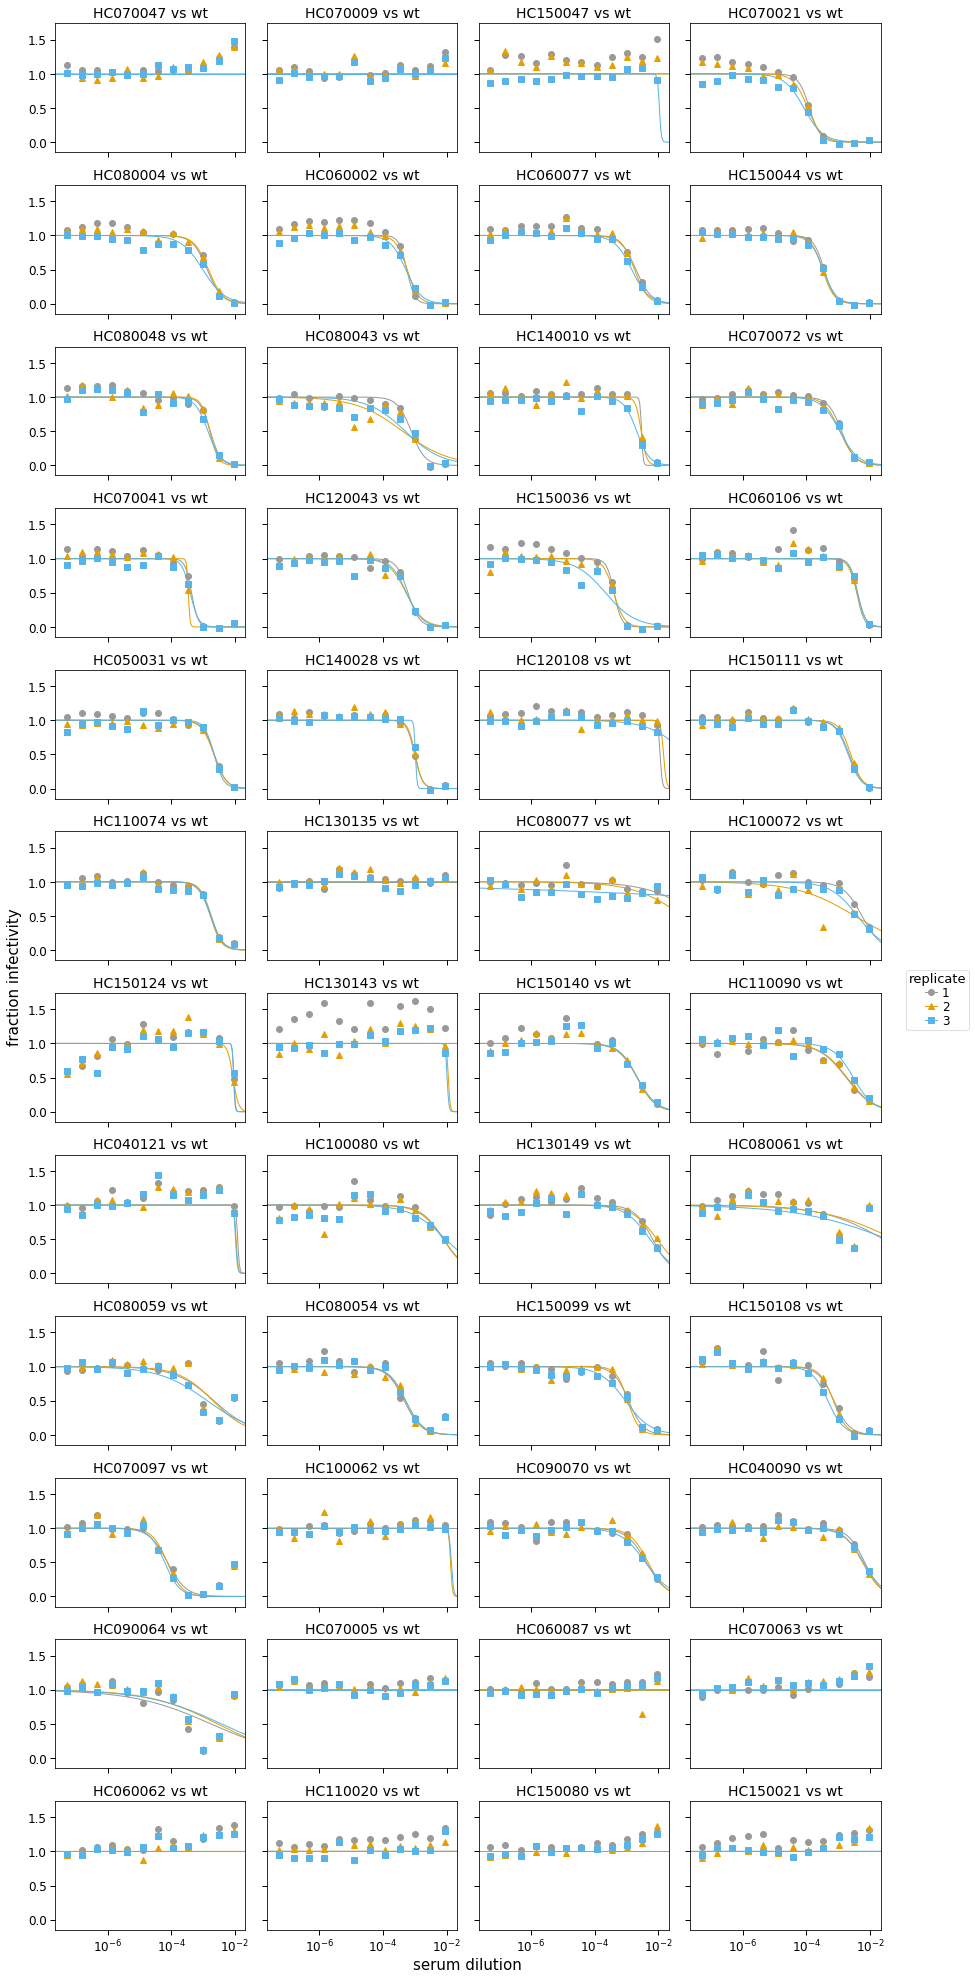

In [10]:
fig_reps, _ = fits.plotReplicates(legendtitle='replicate',
                                  xlabel='serum dilution')

Make plots that just show the across-replicate averages for each serum /
virus combination:

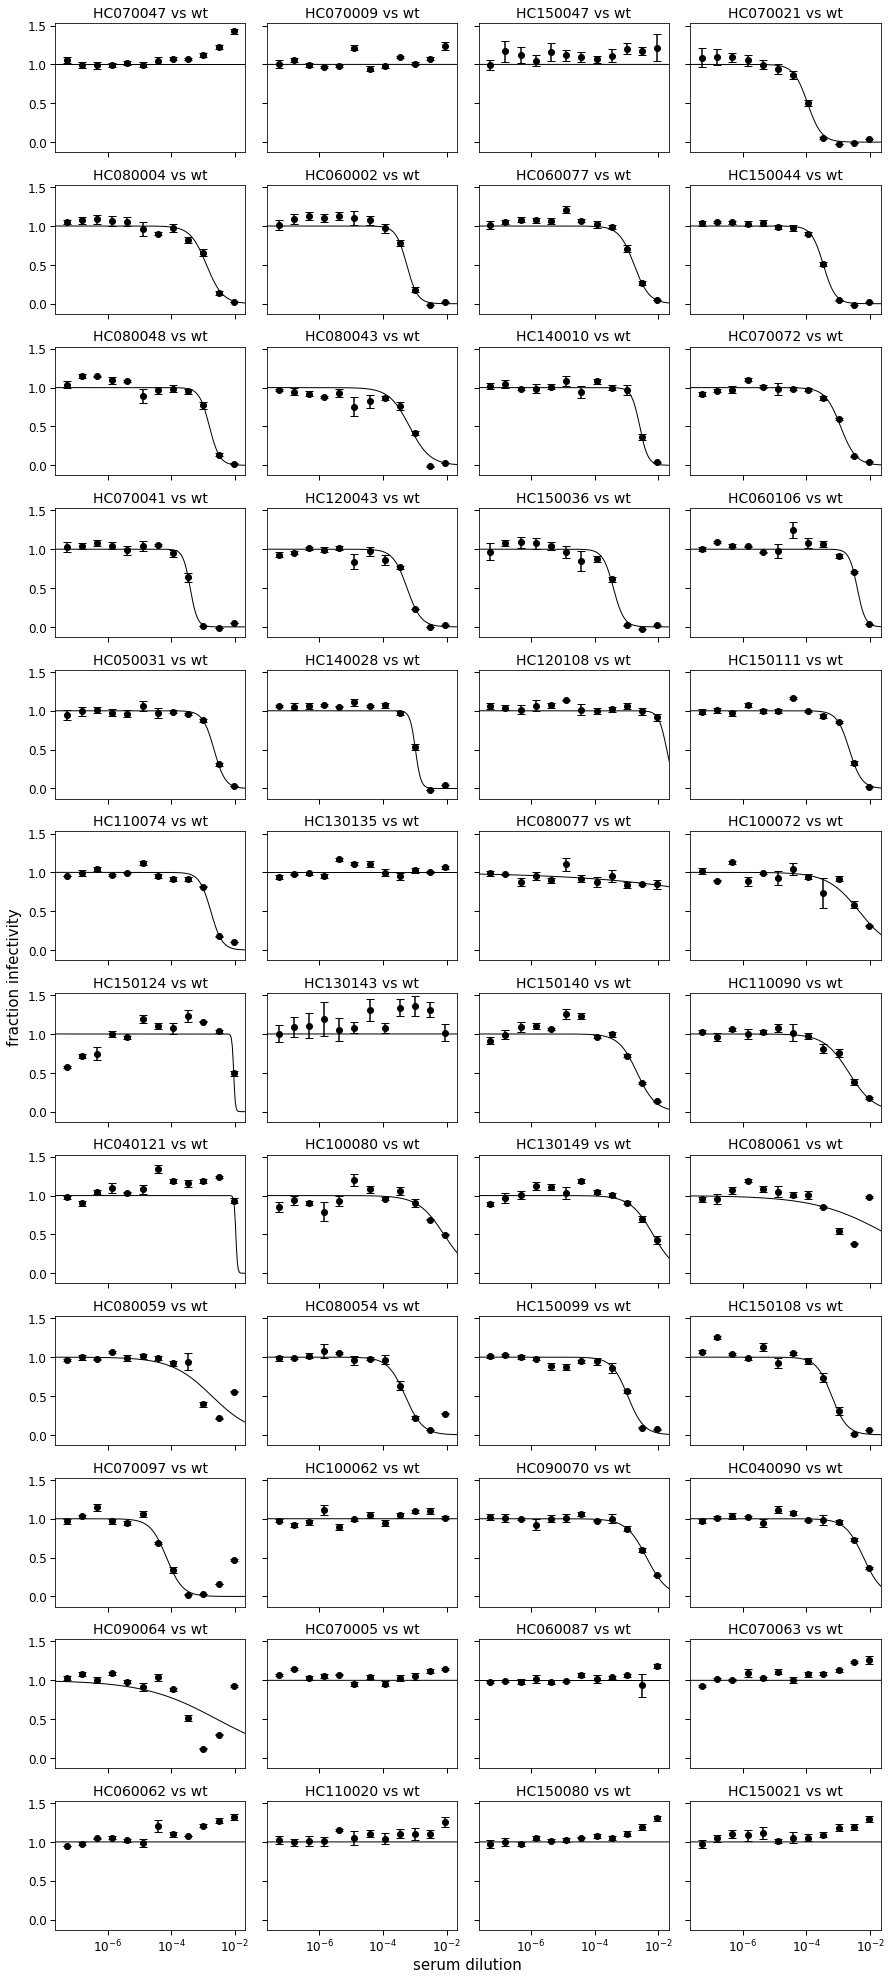

In [11]:
fig_avgs, _ = fits.plotAverages(xlabel='serum dilution')

Save the above neutralization curve plots to PDF files:

In [12]:
for plotname, fig in [('replicates_plot', fig_reps),
                      ('average_plot', fig_avgs)]:
    plotfile = os.path.join(outdir, plotname + '.pdf')
    print(f"Creating plot {plotfile}")
    fig.savefig(plotfile)

Creating plot results/wt_neut_and_bind/replicates_plot.pdf
Creating plot results/wt_neut_and_bind/average_plot.pdf


## Compare neutralization to binding data
Now we want to compare the IC50s from the neutralization curves to the binding titers.
First, we read in the serum information that has the binding titers:

In [13]:
print(f"Reading serum information from {config['neut_serum_info']}")
sera = pd.read_csv(config['neut_serum_info'])
print(f"Read information for {len(sera)} sera.")

Reading serum information from data/neut_serum_info.csv
Read information for 48 sera.


Now we get the neutralization curve fit parameters (including the IC50 and various other inhibitory concentraitons), make sure we have serum information for all sera for which we have curves, and then merge them into a single data frame:

In [14]:
ics = [50, 80, 90, 95]

fitparams = fits.fitParams(ics=ics)

assert set(fitparams['serum']) <= set(sera['serum'])

neut_and_bind = sera.merge(fitparams, on='serum')

Now we plot the correlation between the neutralization titer (reciprocal IC50) and each of the binding titers.
We color points differently depending on whether they are child (<10 years) or adult ($\ge$10 years), and set their shapes based on whether the neutralization titer (IC50) is interpolated (in the range of the data) or simply an upper / lower bound:

Saving plot to results/wt_neut_and_bind/ic50_vs_bind.pdf


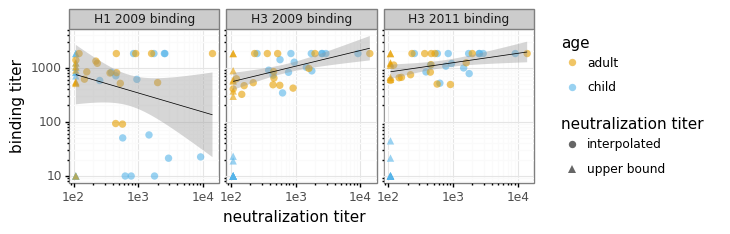

In [15]:
binding_cols = ['H3_2009_binding', 'H3_2011_binding', 'H1_2009_binding']

ic50_vs_bind_plot = (
    neut_and_bind
    .melt(id_vars=['age', 'ic50', 'ic50_bound'],
          value_vars=binding_cols,
          var_name='bind_type',
          value_name='binding titer'
          )
    .assign(bind_type=lambda x: x['bind_type'].str.replace('_', ' '),
            neut_titer=lambda x: 1 / x['ic50'],
            neut_titer_type=lambda x: x['ic50_bound']
                                      .map({'interpolated': 'interpolated',
                                            'upper': 'lower bound',
                                            'lower': 'upper bound'}),
            age=lambda x: numpy.where(x['age'] < 10, 'child', 'adult')
            )
    .pipe(ggplot, aes('neut_titer', 'binding titer',
                      shape='neut_titer_type')) +
          geom_point(aes(color='age'), size=3, alpha=0.6, stroke=0) +
          geom_smooth(method='lm', size=0.3) +
          scale_y_log10() +
          scale_x_log10(name='neutralization titer') +
          scale_color_manual(values=CBPALETTE[1: ]) +
          facet_wrap('~ bind_type') +
          theme_bw() +
          theme(figure_size=(2 * len(binding_cols), 2),
                legend_key=element_blank()) +
          guides(shape=guide_legend(title='neutralization titer'))
          
    )

_ = ic50_vs_bind_plot.draw()

ic50_vs_bind_plotfile = os.path.join(outdir, 'ic50_vs_bind.pdf')
print(f"Saving plot to {ic50_vs_bind_plotfile}")
ic50_vs_bind_plot.save(ic50_vs_bind_plotfile)

Overall, the results in the above plot make sense:
  - There is little relationship between neutralization titer on the H3 Perth/2009 HA and the H1 binding.
  - There is a correlation between H3 binding and H3 neutralization.
  - All the sera that neutralizes binds well, as expected.
  - Some sera bind but do not neutralize well; these sera may bind non-neutralizing epitopes.
  - It appears that there is a stronger association of high binding with high neutralization for children. This
    This is consistent with the basic idea suggested in [Ranjeva et al (2019)](https://www.nature.com/articles/s41467-019-09652-6) that sera from children tends to target HI / neutralizing epitopes, whereas for adults this isn't always the case.

## Examine concentrations for mutational antigenic profiling
Below we tabulate the serum by various inhibitory concentrations to see which ones might have appropriate concentrations for mutational antigenic profiling:

In [16]:
display(HTML(neut_and_bind
             .sort_values('ic50')
             [['serum'] + [f"ic{ic}_str" for ic in ics]]
             .to_html(index=False)
             ))

serum,ic50_str,ic80_str,ic90_str,ic95_str
HC070097,7.14e-05,0.000161,0.000259,0.000401
HC070021,0.000109,0.000219,0.000328,0.000478
HC150044,0.000341,0.00062,0.000878,0.00121
HC150036,0.000388,0.00066,0.000901,0.0012
HC070041,0.000396,0.000567,0.000699,0.000849
HC080054,0.000503,0.00121,0.00202,0.00324
HC060002,0.000562,0.000968,0.00133,0.00178
HC120043,0.000573,0.00116,0.00175,0.00256
HC150108,0.000625,0.00136,0.00214,0.00325
HC080043,0.000684,0.00191,0.00348,0.00605


We also write all of the data on the curve fits and binding to a file:

In [17]:
neut_and_bind_file = os.path.join(outdir, 'neut_and_bind.csv')
print(f"Writing neutralization and binding data to {neut_and_bind_file}")
neut_and_bind.to_csv(neut_and_bind_file)

Writing neutralization and binding data to results/wt_neut_and_bind/neut_and_bind.csv
